Author: Kristopher Darnell  
Date: July 25, 2021
    
# Summary of this notebook
In this notebook, I load the API I built (`proximity_heatmap.py`), which is designed to compute the proximity betwween various fields defined in a geospatial dataset. You might use this sort of framework for finding the probable intersection of geological facies. I generate a subset of data and compare run times for four iterations of the API. 
* The first iteration clocks a brute-force search algorithm (~180 seconds) 
* The second iteration clocks that same algorithm but with specific "query" points using a buffer around the smaller of the two rock type layers. (~110 seconds)
* The third iteration clocks a modified algorithm that leverages k-d tree in `scipy.spatial` (~30 seconds)
* The fourth iteration clocks the combination of a k-d tree with the buffered filtering (~7 seconds)


**Using the analysis below, it seems the k-d tree implementation is the ideal algorithm for performing this sort of task.**

### Load libraries including the my class `ProximityHeatMap` 

In [1]:
from proximity_heatmap import ProximityHeatMap, KDTreeProximityHeatMap,INDEX_LIKE
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import time
from geocube.api.core import make_geocube
import typing as t

/Users/kris/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


# I will show how to use the API by looking for the proximity between the class "granodioritic intrusive rocks" and classes matching the pattern r".*ultramafic" 

### Measure computation time of the brute-force algorithm using the API

In [2]:
start = time.time()
ph = ProximityHeatMap("Data/BedrockP.shp")
ph.generate_twoclass_raster(
    layer="rock_type",
    class_one="granodioritic intrusive rocks",
    class_two=r".*ultramafic",
    resolution=100
)
ph.make_twoclass_proximity_array(length=1e4)
ph.make_twoclass_heatmap(length=1e4)
end = time.time()
print(f"Completed in {end - start} seconds")

Completed in 180.06124114990234 seconds


### Now, find relevant indices for the heatmap by using the smaller of the two geometries to create a buffer around it and then compute heatmap at those points only

In [3]:
tmp = ph.geo_df.copy().query("new_type == 2")
tmp["geometry"] = ph.geo_df.geometry.buffer(10e3)
out = make_geocube(tmp, like=ph.raster)
use_indices = np.argwhere(~np.isnan(out.new_type.values))

### Measure computation time when the computation points are reduced

In [4]:
start = time.time()
ph2 = ProximityHeatMap("Data/BedrockP.shp")
ph2.generate_twoclass_raster(
    layer="rock_type",
    class_one="granodioritic intrusive rocks",
    class_two=r".*ultramafic",
    resolution=100
)
ph2.make_twoclass_proximity_array(length=1e4, indices=use_indices)
ph2.make_twoclass_heatmap(length=1e4)
end = time.time()
print(f"Completed in {end - start} seconds")

Completed in 109.68010902404785 seconds


### Now, attempt to reduce computation by changing the underlying algorithm 

We will leverage `KDTree.query` in `scipy.spatial` with a raveled and vectorized version of our matrices. Thus, we can inherit the class `ProximityHeatMap`, change the definition of indices, and create a new `proximity_array` method.

### Measure computation time when we replace the distance measurement with one based on k-d trees

In [5]:
start = time.time()
sph = KDTreeProximityHeatMap("Data/BedrockP.shp")
sph.generate_twoclass_raster(
    layer="rock_type",
    class_one="granodioritic intrusive rocks",
    class_two=".*ultramafic",
    resolution=100
)
sph.make_twoclass_proximity_array(length=1e4)
sph.make_twoclass_heatmap(length=1e4)
end = time.time()
print(f"Completed in {end - start} seconds")

Completed in 33.416123151779175 seconds


### Measure computation time when the computation points are reduced and we use k-d trees

In [6]:
start = time.time()
sph2 = KDTreeProximityHeatMap("Data/BedrockP.shp")
sph2.generate_twoclass_raster(
    layer="rock_type",
    class_one="granodioritic intrusive rocks",
    class_two=".*ultramafic",
    resolution=100
)
sph2.make_twoclass_proximity_array(length=1e4, indices=~np.isnan(out.new_type.values))
sph2.make_twoclass_heatmap(length=1e4)
end = time.time()
print(f"Completed in {end - start} seconds")

Completed in 7.158345937728882 seconds


### Let's sanity-check the results to make the output is nearly identical for all

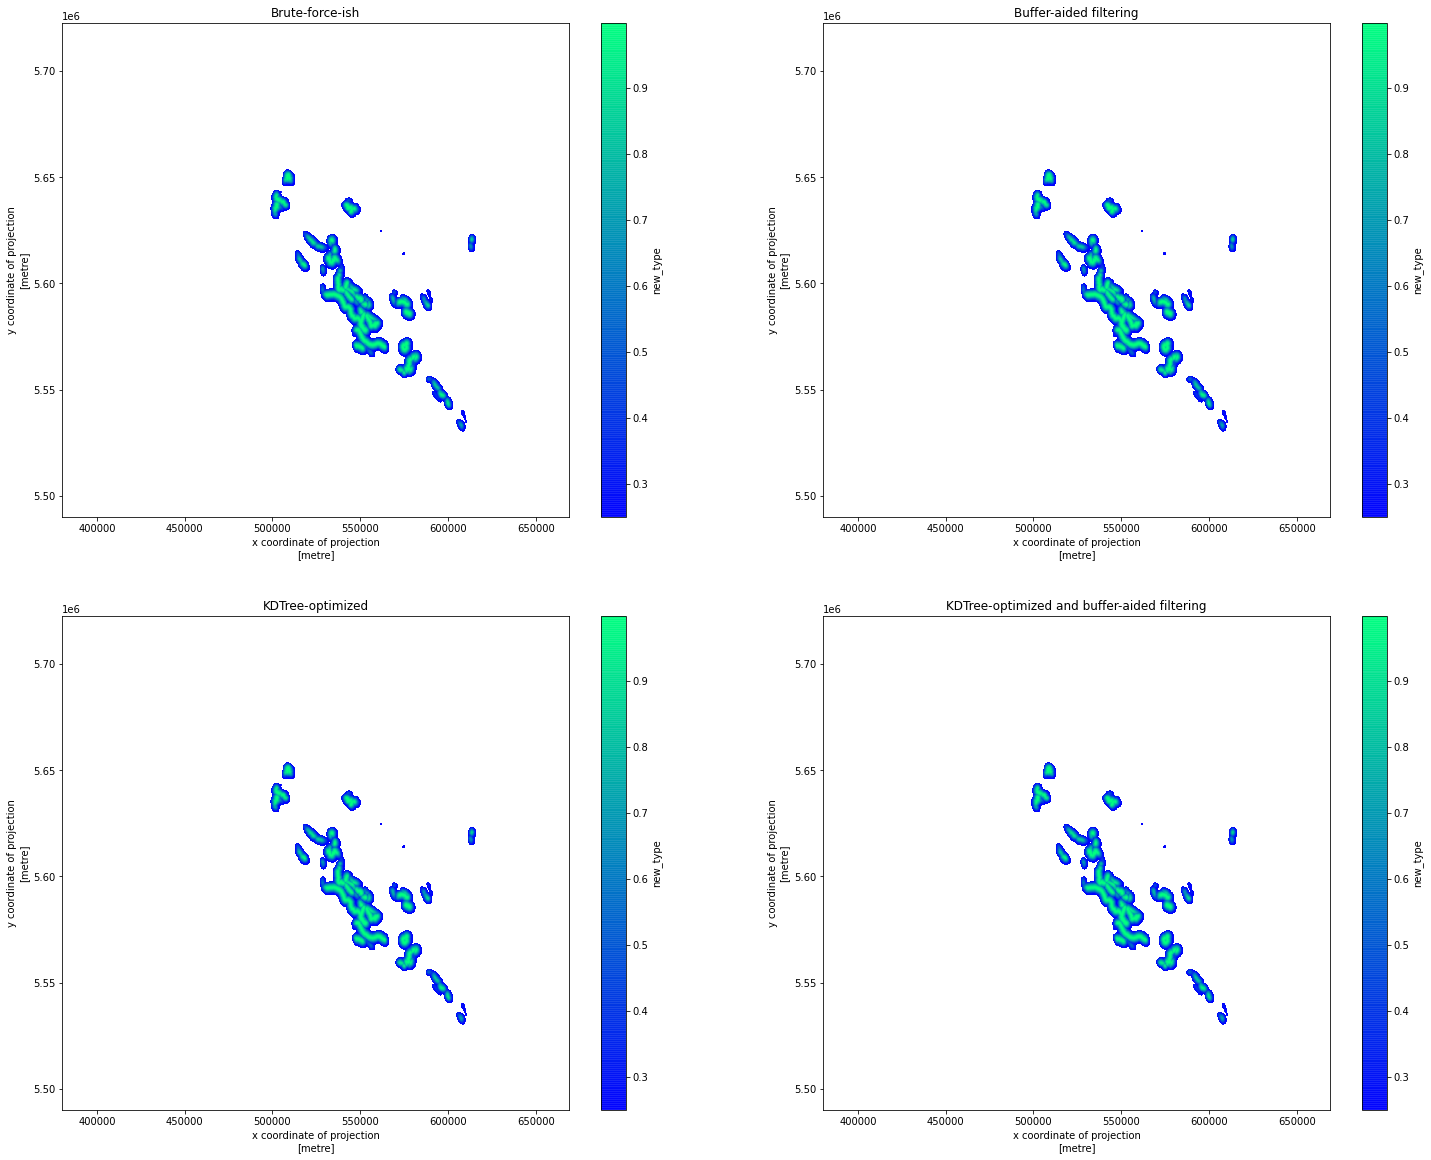

In [7]:
plt.figure(figsize=(25, 20))
plt.subplot(2, 2, 1)
ph.heatmap_xarray.where(lambda x: x > 0.25).plot(alpha=0.9, cmap='winter')
plt.title("Brute-force-ish")

plt.subplot(2, 2, 2)
ph2.heatmap_xarray.where(lambda x: x > 0.25).plot(alpha=0.9, cmap='winter')
plt.title("Buffer-aided filtering")

plt.subplot(2, 2, 3)
sph.heatmap_xarray.where(lambda x: x > 0.25).plot(alpha=0.9, cmap='winter')
plt.title("KDTree-optimized")

plt.subplot(2, 2, 4)
sph2.heatmap_xarray.where(lambda x: x > 0.25).plot(alpha=0.9, cmap='winter')
plt.title("KDTree-optimized and buffer-aided filtering")
plt.show()

### The KDTree implementation is a HUGE speed improvement. Buffering helps us by a significant factor, though!